In [ ]:
pip install darts

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist
from darts.datasets import AirPassengersDataset

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

#Read data and build a TimeSeries

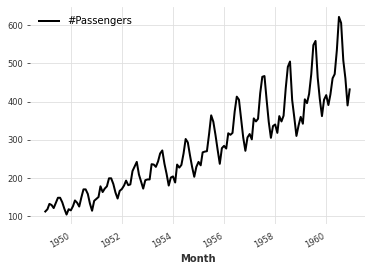

In [ ]:
series = AirPassengersDataset().load()
series.plot()

#Creating a training and validation series

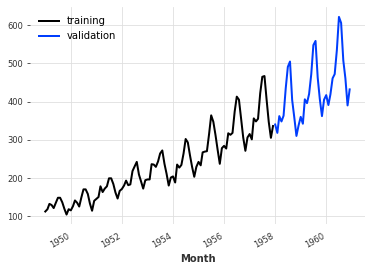

In [ ]:
train, val = series.split_before(pd.Timestamp('19580101'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

#Playing with toy models

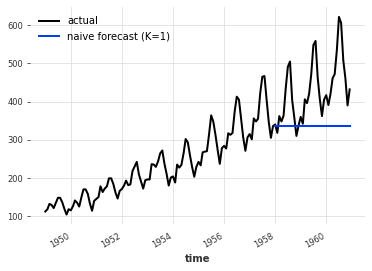

In [ ]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')
plt.legend();

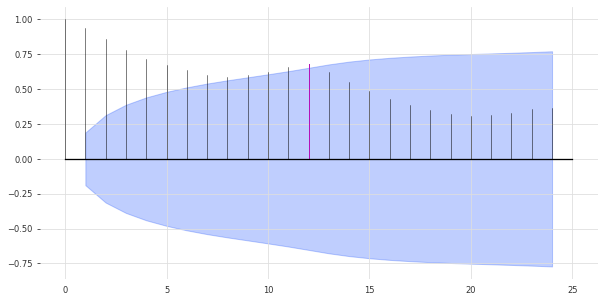

In [ ]:
plot_acf(train, m = 12, alpha = .05)

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 12.


# A less naive model

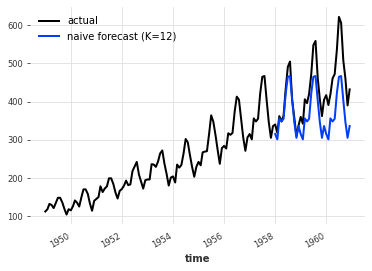

In [ ]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=12)')
plt.legend();

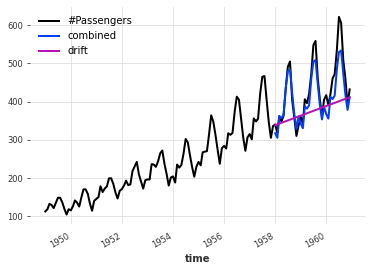

In [ ]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend();

In [ ]:
print("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
      mape(series, combined_forecast)))

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


#More models


In [ ]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

model Exponential smoothing obtains MAPE: 5.11%
model Prophet obtains MAPE: 9.74%
model Auto-ARIMA obtains MAPE: 11.65%
model Theta(2) obtains MAPE: 8.15%


#The Theta method

In [ ]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [ ]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

The MAPE is: 4.40, with theta = -3.5102040816326543.


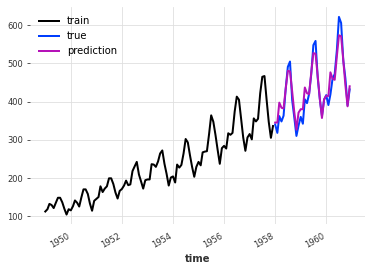

In [ ]:
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend();

#Backtesting: simulate historical forecasting

100%|██████████| 70/70 [00:02<00:00, 32.53it/s]


Average error (MAPE) over all historical forecasts: 6.133398705145922
Median error (MAPE) over all historical forecasts: 4.205415090465937


100%|██████████| 70/70 [00:02<00:00, 33.54it/s]


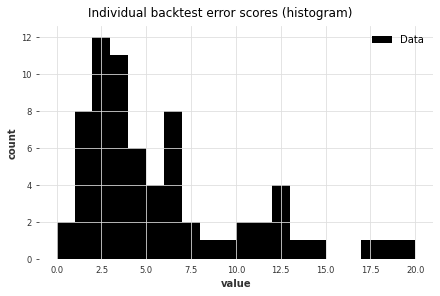

In [ ]:
best_theta_model = Theta(best_theta)

average_error = best_theta_model.backtest(series, start=pd.Timestamp('19550101'), forecast_horizon=3, verbose=True)
median_error = best_theta_model.backtest(series, start=pd.Timestamp('19550101'), forecast_horizon=3, reduction=np.median, verbose=True)
print("Average error (MAPE) over all historical forecasts: {}".format(average_error))
print("Median error (MAPE) over all historical forecasts: {}".format(median_error))

raw_errors = best_theta_model.backtest(series, start=pd.Timestamp('19550101'), forecast_horizon=3, reduction=None, verbose=True)
plot_hist(raw_errors, bins=np.arange(0, max(raw_errors), 1), title='Individual backtest error scores (histogram)')

historical_fcast_theta = best_theta_model.historical_forecasts(series, start=pd.Timestamp('19550101'), forecast_horizon=3, verbose=True)

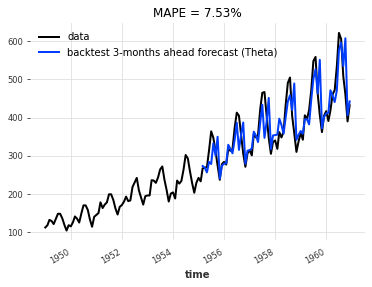

In [ ]:
series.plot(label='data')
historical_fcast_theta.plot(label='backtest 3-months ahead forecast (Theta)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_theta, series)))
plt.legend();

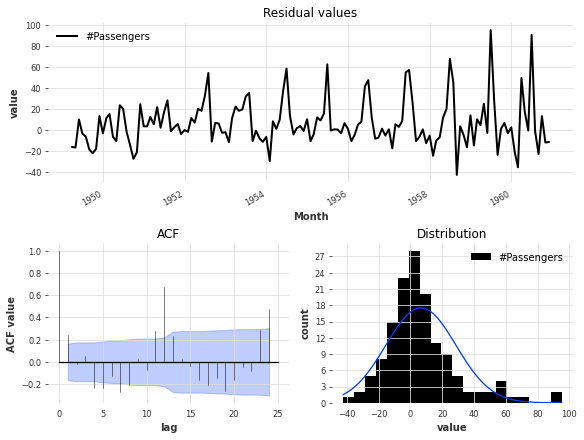

In [ ]:
plot_residuals_analysis(best_theta_model.residuals(series))

100%|██████████| 70/70 [00:08<00:00,  8.04it/s]


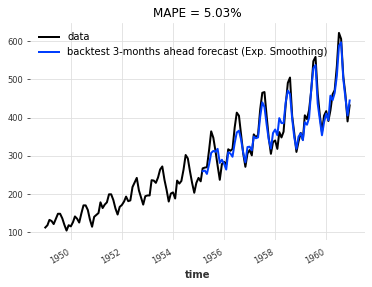

In [ ]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(series, start=pd.Timestamp('19550101'), forecast_horizon=3, verbose=True)

series.plot(label='data')
historical_fcast_es.plot(label='backtest 3-months ahead forecast (Exp. Smoothing)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_es, series)))
plt.legend()
plt.show()

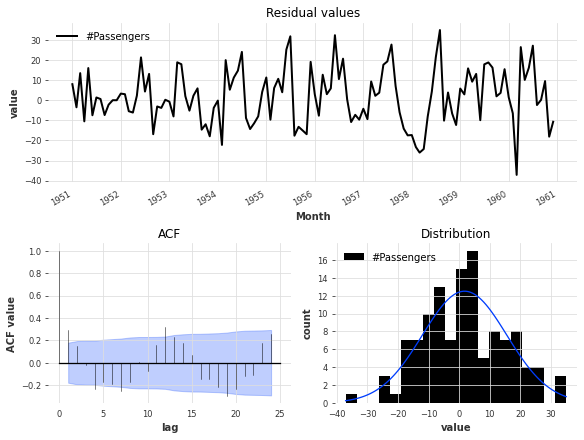

In [ ]:
plot_residuals_analysis(model_es.residuals(series))

#Probabilistic Forecasts

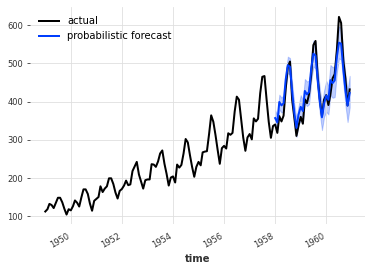

In [ ]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label='actual')
probabilistic_forecast.plot(label='probabilistic forecast')
plt.legend()
plt.show()

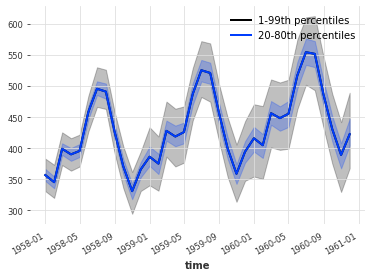

In [ ]:
probabilistic_forecast.plot(low_quantile=0.01, high_quantile=0.99, label='1-99th percentiles')
probabilistic_forecast.plot(low_quantile=0.2, high_quantile=0.8, label='20-80th percentiles')

#Ensembling several predictions

In [ ]:
models = [NaiveSeasonal(6), NaiveSeasonal(12), NaiveDrift()]

model_predictions = [m.historical_forecasts(series,
                                            start=pd.Timestamp('19561201'),
                                            forecast_horizon=12,
                                            stride=12,
                                            last_points_only=False,
                                            verbose=True)
                     for m in models]

model_predictions = [reduce((lambda a, b: a.append(b)), model_pred) for model_pred in model_predictions]

100%|██████████| 4/4 [00:00<00:00, 94.30it/s]


In [ ]:
model_predictions_stacked = model_predictions[0]
for model_prediction in model_predictions[1:]:
    model_predictions_stacked = model_predictions_stacked.stack(model_prediction)

In [ ]:
""" We build the regression model, and tell it to use the current predictions
"""
regr_model = RegressionModel(lags=None, lags_future_covariates=[0])

""" Our target series is what we want to predict (the actual data)
    It has to have the same time index as the features series:
"""
series_target = series.slice_intersect(model_predictions[0])

""" Here we backtest our regression model
"""
ensemble_pred = regr_model.historical_forecasts(
    series=series_target, future_covariates=model_predictions_stacked,
    start=pd.Timestamp('19580101'), forecast_horizon=3, verbose=True
)

100%|██████████| 33/33 [00:00<00:00, 33.07it/s]



Regression coefficients for the individual models:
Learned coefficient for Naive seasonal model, with K=6: -0.01
Learned coefficient for Naive seasonal model, with K=12: 1.09
Learned coefficient for Naive drift model: 0.10


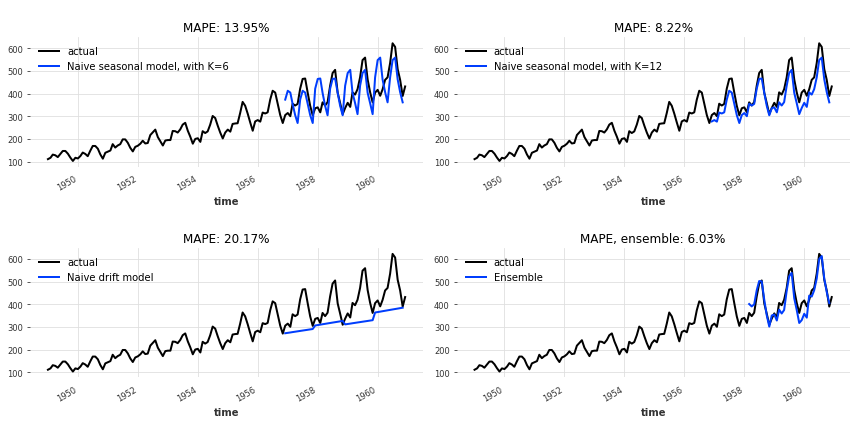

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
ax = ax.ravel()

for i, m in enumerate(models):
    series.plot(label='actual', ax=ax[i])
    model_predictions[i].plot(label=str(m), ax=ax[i])

    # intersect last part, to compare all the methods over the duration of the ensemble forecast
    model_pred = model_predictions[i].slice_intersect(ensemble_pred)

    mape_model = mape(series, model_pred)
    ax[i].set_title('\nMAPE: {:.2f}%'.format(mape_model))
    ax[i].legend()

series.plot(label='actual', ax=ax[3])
ensemble_pred.plot(label='Ensemble', ax=ax[3])
ax[3].set_title('\nMAPE, ensemble: {:.2f}%'.format(mape(series, ensemble_pred)))
ax[3].legend()

print('\nRegression coefficients for the individual models:')
for i, m in enumerate(models):
    print('Learned coefficient for {}: {:.2f}'.format(m, regr_model.model.coef_[i]))
plt.tight_layout();

#RegressionEnsembleModel approach

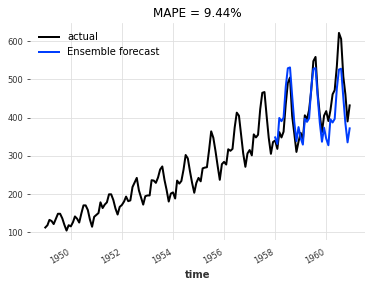

In [ ]:
ensemble_model = RegressionEnsembleModel(
    forecasting_models=[NaiveSeasonal(6), NaiveSeasonal(12), NaiveDrift()],
    regression_train_n_points=12)

ensemble_model.fit(train)
ensemble_pred = ensemble_model.predict(36)

series.plot(label='actual')
ensemble_pred.plot(label='Ensemble forecast')
plt.title('MAPE = {:.2f}%'.format(mape(ensemble_pred, series)))
plt.legend();

100%|██████████| 34/34 [00:02<00:00, 15.32it/s]


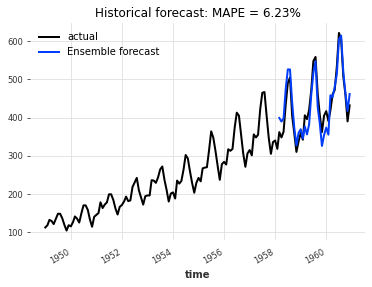

In [ ]:
ensemble_pred_hist = ensemble_model.historical_forecasts(series,
                                                    start=pd.Timestamp('19580101'),
                                                    forecast_horizon=3,
                                                    verbose=True)
series.plot(label='actual')
ensemble_pred_hist.plot(label='Ensemble forecast')
plt.title('Historical forecast: MAPE = {:.2f}%'.format(mape(ensemble_pred_hist, series)))
plt.legend();